In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import sys

sys.path.append('../../../Enhancer')  
from train.utils import EnhancerDataset, split_dataset, train_model, regression_model_plot, plot_filter_weight
from model.model import ExplaiNN3_interact

In [10]:

def generate_random_dna(length, num_dna, motifA, motifB, directionality_is_true, resample = False):
    """Generate random DNA sequences and calculate the motif distance score."""
    if (len(motifA) + len(motifB)) > (length - 10):
        raise ValueError('Length of motif A plus motif B greater then dna length minus 10')
    if len(motifA) > length // 3 or len(motifB) > length // 3:
        warnings.warn("One of the motifs is longer than one-third of the DNA length.")
    
    dna_sequences = []
    scores = []
    proportion = {'no_A_no_B': 0, 'no_A_has_B': 0, 'has_A_no_B':0, 'has_A_has_B':0, 'A_before_B': 0, 'B_before_A': 0}
    
    nucleotides = ['A', 'T', 'C', 'G']
    
    for _ in range(num_dna):
        # Generate a random DNA sequence
        dna = ''.join(random.choices(nucleotides, k=length))
        
        # Decide randomly whether to insert motifA and motifB
        insert_motifA = random.choice([True, False])
        insert_motifB = random.choice([True, False])
        if resample == True:
            num_zero_score = proportion['no_A_no_B'] + proportion['no_A_has_B'] + proportion['has_A_no_B']
            num_has_score = proportion['has_A_has_B']
            if num_zero_score > int(num_dna/2):
                insert_motifA = True
                insert_motifB = True
            elif num_has_score > int(num_dna/2):
                insert_motifA = False
                insert_motifB = False

        index_a = -1
        index_b = -1
        
        if insert_motifA:
            # Pick a random portion of dna to get replaced by motifA
            index_a = random.randint(0, length - len(motifA))
            dna = dna[:index_a] + motifA + dna[index_a + len(motifA):]
        
        if insert_motifB:
            not_inserted_yet = True
            while not_inserted_yet:
                index_b = random.randint(0, length - len(motifB))
                # Check if the selected index b would cause motifB overlap motifA
                if (index_b + len(motifB) <= index_a) or (index_a + len(motifA) <= index_b):
                    dna = dna[:index_b] + motifB + dna[index_b + len(motifB):]
                    not_inserted_yet = False
        
        dna_sequences.append(dna)

        if insert_motifA and insert_motifB:
            proportion['has_A_has_B'] += 1
            if index_a < index_b:
                proportion['A_before_B'] += 1
            elif index_a > index_b:
                proportion['B_before_A'] += 1
        elif insert_motifA and not insert_motifB:
            proportion['has_A_no_B'] += 1
        elif not insert_motifA and insert_motifB:
            proportion['no_A_has_B'] += 1
        elif not insert_motifA and not insert_motifB:
            proportion['no_A_no_B'] += 1
        
        # Calculate the motif distance score
        motifs_a = list(find_all_motifs(dna, motifA)) if insert_motifA else []
        motifs_b = list(find_all_motifs(dna, motifB)) if insert_motifB else []
        
        score = 0
        if motifs_a and motifs_b:
            for (start_a, end_a) in motifs_a:
                for (start_b, end_b) in motifs_b:
                    if end_a <= start_b:
                        distance = start_b - end_a
                    elif end_b <= start_a:
                        distance = start_a - end_b
                    else:
                        overlap_start = max(start_a, start_b)
                        overlap_end = min(end_a, end_b)
                        overlap_length = overlap_end - overlap_start
                        longer_motif_length = max(end_a - start_a, end_b - start_b)
                        distance = overlap_length / longer_motif_length
                    if distance < float('inf'):
                        score = math.exp(-0.2*distance)
                        #score = 2*math.exp(-(distance-4)**2/4)
                        
                    
                    if directionality_is_true and start_b < start_a:
                        score = 0
            
        scores.append(score) 
    return dna_sequences, scores, proportion

def find_all_motifs(sequence, motif):
    """Find all occurrences of a motif in the sequence, returning start and end positions."""
    start = 0
    motif_length = len(motif)
    while True:
        start = sequence.find(motif, start)
        if start == -1:
            break
        end = start + motif_length
        yield (start, end)
        start += 1  # Move start forward for next search to allow overlapping motifs

# Example usage
dna_sequences, scores, portions = generate_random_dna(length=608, num_dna=50000, motifA='CCTTAAGGAGAGTCTCTTT', motifB='CAAGGAGTTCTTACGGAGC', directionality_is_true=False, resample = True)
print(portions)

df = pd.DataFrame({'sequence':dna_sequences, 'score': scores})
#pickle_file_path = "/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/synthetic_sequence_sampled.pl"
#df.to_pickle(pickle_file_path)

#df = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/synthetic_sequence.csv")



{'no_A_no_B': 8315, 'no_A_has_B': 8275, 'has_A_no_B': 8411, 'has_A_has_B': 24999, 'A_before_B': 12473, 'B_before_A': 12526}


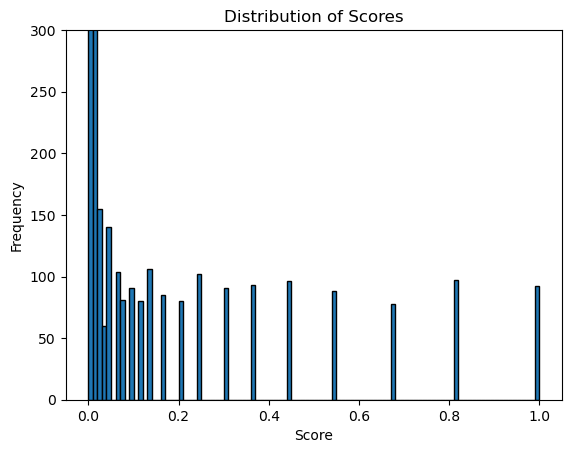

In [3]:
df = pd.DataFrame({'sequence':dna_sequences, 'score': scores})
# Plot histogram of scores
plt.hist(df['score'], bins=100, edgecolor='black')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.ylim(0,300)
plt.show()

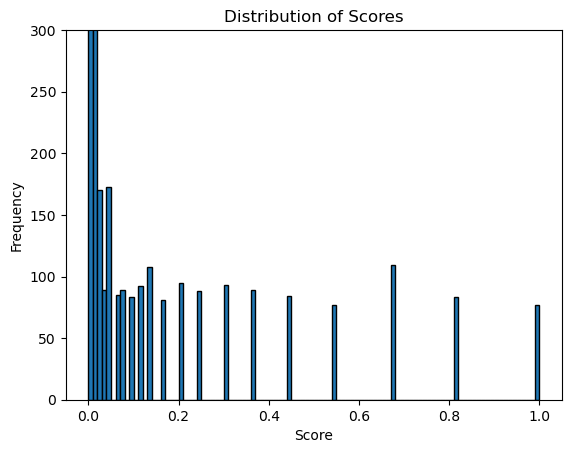

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/200, Loss: 0.2328
Epoch 1/200, Step 200/200, Loss: 0.0347
Epoch 1/200: Train Loss: 0.0706 , Test Loss: 0.0228
------------------------Evaluation------------------------
Label 1: MSE=0.0228, RMSE=0.1511, MAE=0.1112, R^2=-3.0885, Pearson=-0.0184, Spearman=-0.0131
Overall (Flattened): MSE=0.0228, RMSE=0.1511, MAE=0.1112, R^2=-3.0885, Pearson=-0.0184, Spearman=-0.0131
----------------------------------------------------------
Epoch 2/200, Step 1/200, Loss: 0.0261
Epoch 2/200, Step 200/200, Loss: 0.0081
Epoch 2/200: Train Loss: 0.0184 , Test Loss: 0.0109
------------------------Evaluation------------------------
Label 1: MSE=0.0109, RMSE=0.1045, MAE=0.0674, R^2=-0.9552, Pearson=-0.0119, Spearman=-0.0043
Overall (Flattened): MSE=0.0109, RMSE=0.1045, MAE=0.0674, R^2=-0.9552, Pearson=-0.0119, Spearman=-0.0043
----------------------------------------------------------
Epoch 3/200, Step 1/200, Loss: 0.0158
Epoch 3/200, Step 200/20

In [14]:
# Define some hyperparameters
seed = 42
batch = 200
num_cnns = 90
learning_rate = 4e-4
target_labels = ['Motif Distance Score']
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/ExplaiNN_Interaction_synthetic_motif_results'


#df = pd.DataFrame({'sequence':dna_sequences, 'score': scores})
#df = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/synthetic_sequence.csv")
df = pd.read_pickle('/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/synthetic_sequence_sampled.pl')
# Plot histogram of scores
plt.hist(df['score'], bins=100, edgecolor='black')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.ylim(0,300)
plt.show()

train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

train = EnhancerDataset(train, feature_list=['score'], scale_mode = 'none')
test = EnhancerDataset(test, feature_list=['score'], scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=True)

input_model = ExplaiNN3_interact(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, device  = train_model(input_model, train_loader, test_loader, 
                                                                                                                            target_labels=target_labels,num_epochs=200, 
                                                                                                                        batch_size=batch, learning_rate=learning_rate, 
                                                                                                                        criteria='mse',optimizer_type = "adam", patience=10, 
                                                                                                                        seed = seed, save_model= True, dir_path=output_dir)

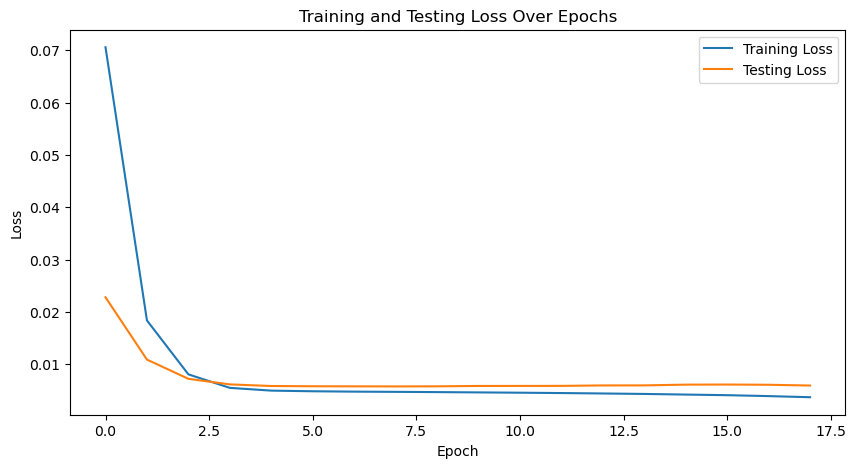

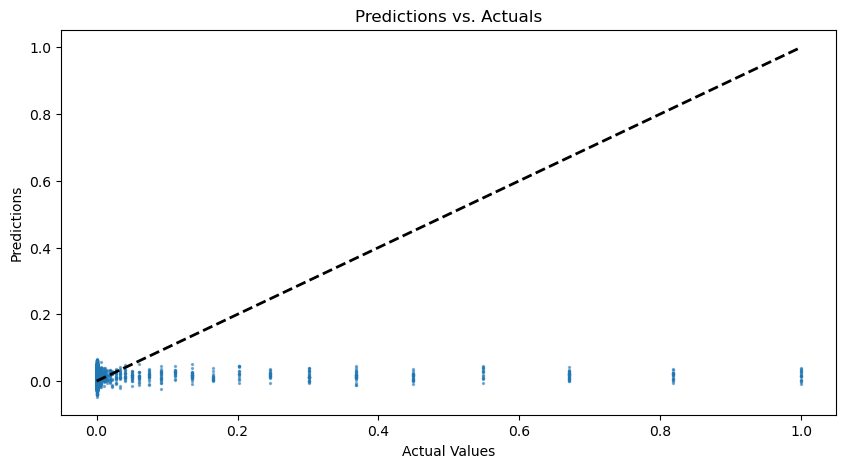

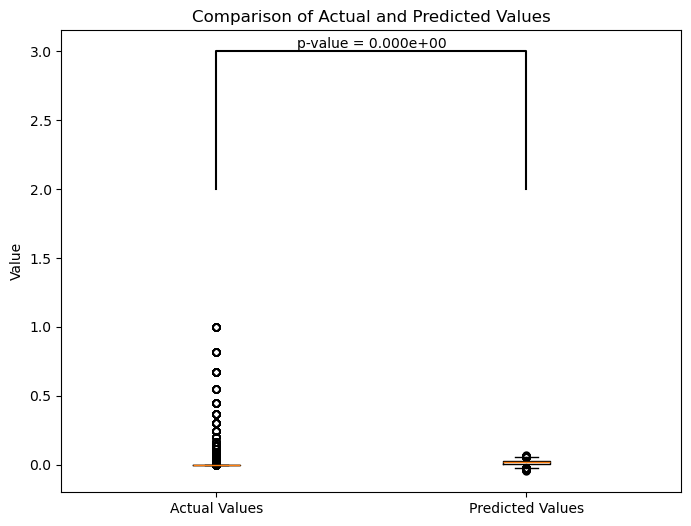

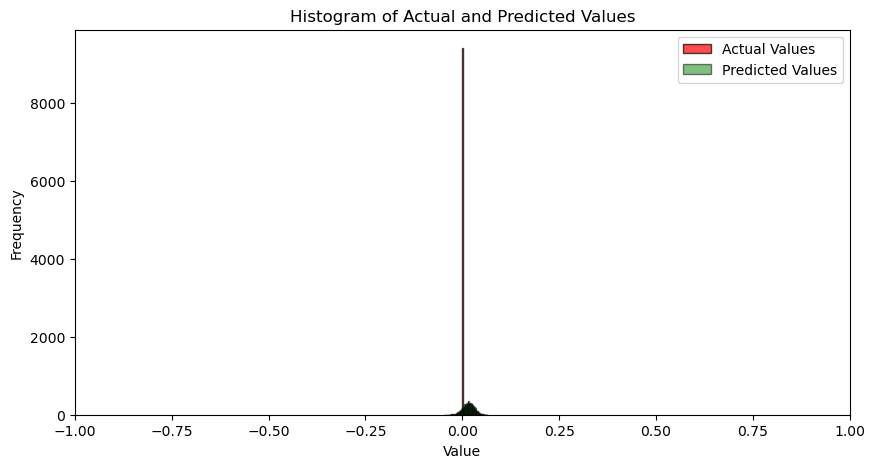

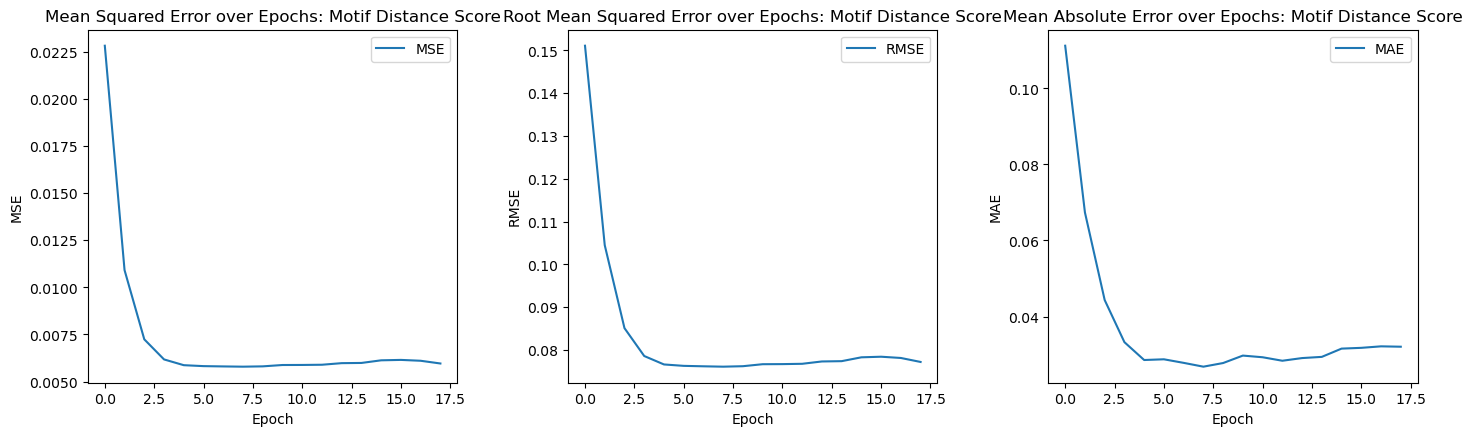

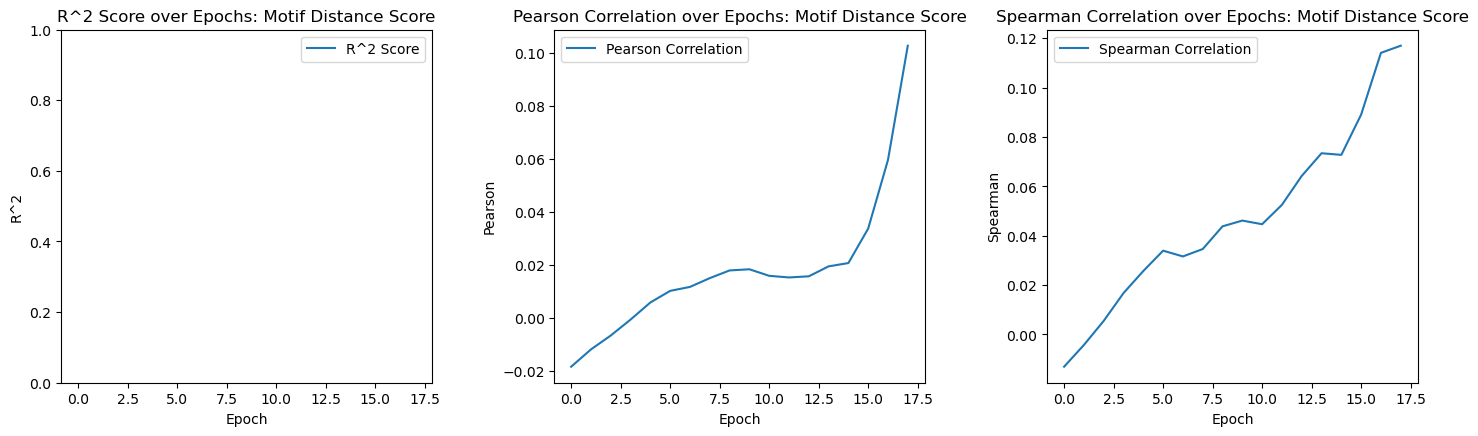

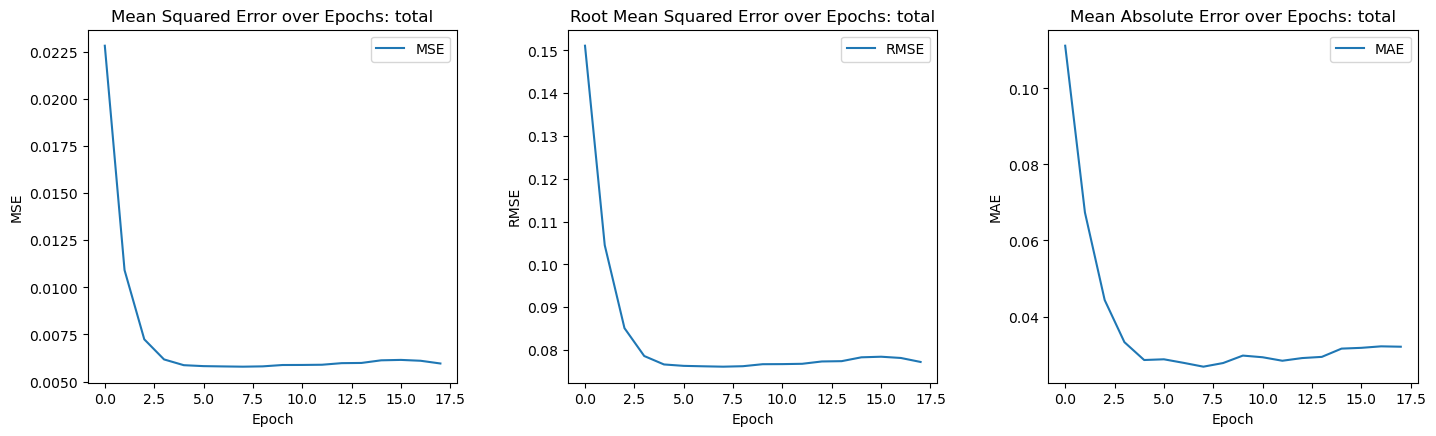

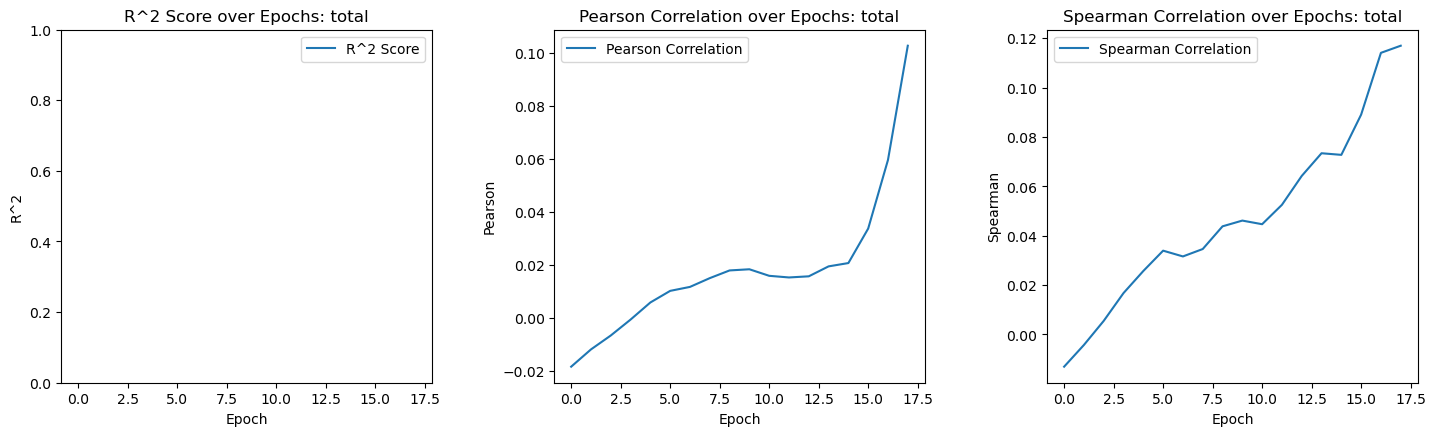

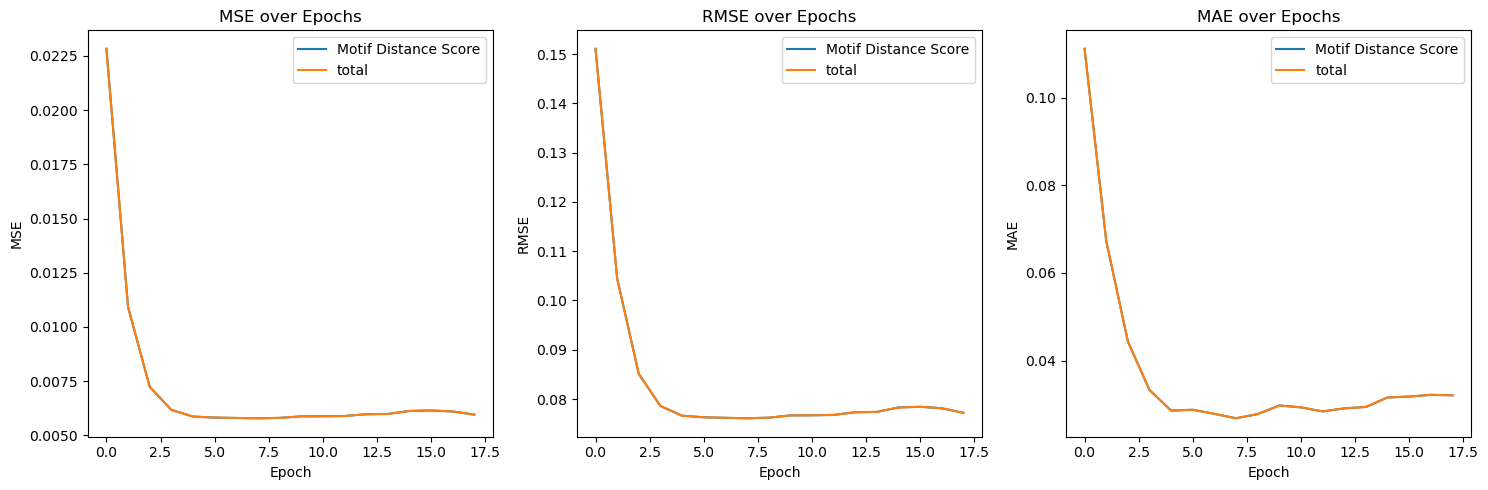

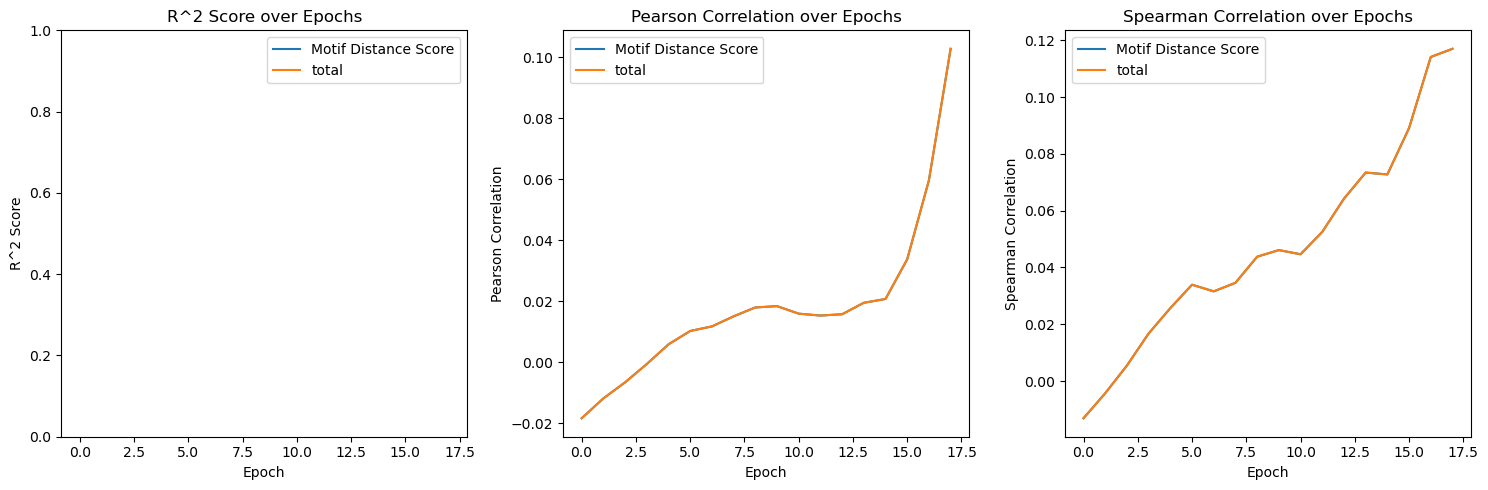

MSE: 0.0060, RMSE: 0.0772, MAE: 0.0321
R^2: -0.0675, Pearson Correlation: 0.1028, Spearman Correlation: 0.1170


In [15]:
#best_r2_epoch = 18

model_path = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/ExplaiNN_Interaction_synthetic_motif_results/model_epoch_{best_r2_epoch}.pth'
dir_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/ExplaiNN_Interaction_synthetic_motif_results'
mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    device, results, label_mode = "score", save_plot = True, dir_path = dir_path, model_path = model_path, best_model=best_r2_epoch)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

In [3]:
filter_size = 19
num_cnns = 90
filter_size = 19
best_r2_epoch = 120
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
explainn = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = filter_size, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training
explainn.to(device)  

weight_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/ExplaiNN_synthetic_motif_results/model_epoch_{best_r2_epoch}.pth'
explainn.load_state_dict(torch.load(weight_file))
explainn.eval()

ExplaiNN3(
  (linears): Sequential(
    (0): Conv1d(360, 90, kernel_size=(19,), stride=(1,), groups=90)
    (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(7560, 9000, kernel_size=(1,), stride=(1,), groups=90)
    (7): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(9000, 90, kernel_size=(1,), stride=(1,), groups=90)
    (11): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=90, out_features=1, bias=True)
)

In [4]:
batch = 300
df = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/synthetic_sequence.csv")

dataset = EnhancerDataset(df, label_mode='score', scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)
print(predictions.shape)

(30000, 1)


Number of samples before filtering: 30000
torch.Size([11197, 4, 608])
torch.Size([11197, 1])
Number of samples after filtering: 11197


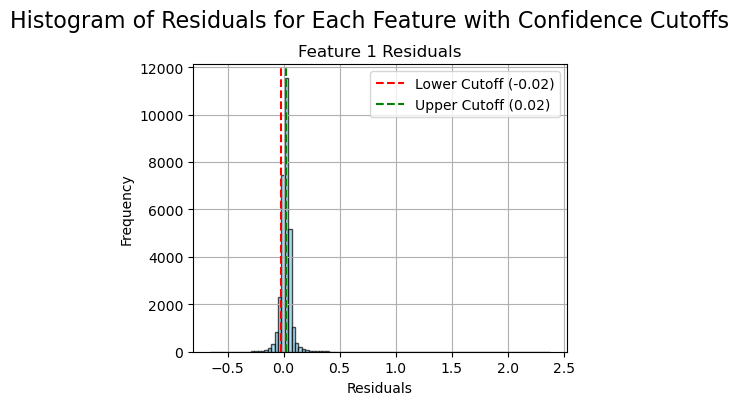

In [5]:
# Prepare features and labels:
# --(Features): Transform all sequences into one-hot encodings
# --(Labels): Use GFP+ and GFP- as labels
dataset = EnhancerDataset(df, label_mode='score', scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)

"""Now filter out low confident predictions"""
# Calculate absolute residuals
residuals = np.abs(labels - predictions)

# Define the upper bound of residuals
upper_bound = 0.02

# Create a mask for filtering out samples with low confident precition (abs(residual) > upper_bound)
mask = (residuals <= upper_bound).all(axis=1)

# Get sequences and labels from dataset
data_inp = []
data_out = []
# Iterate over the DataLoader
for batch_features, batch_labels in dataset:
    data_inp.append(batch_features)
    data_out.append(batch_labels)
# Concatenate all the batches into single tensors
data_inp = torch.cat(data_inp, dim=0)
data_out = torch.cat(data_out, dim=0)

# Use the mask to filter the predictions and labels
print(f'Number of samples before filtering: {len(data_inp)}')
data_inp = data_inp[mask]
data_out = data_out[mask]
print(data_inp.shape)
print(data_out.shape)

print(f'Number of samples after filtering: {len(data_inp)}')

# Create new dataloader with filtered high confident samples
dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch, shuffle=False,)

# Plot histogram of residuals with adjusted cutoff lines
# 1. Compute residuals (not absolute)
residuals = labels - predictions

# 2. Define bounds for plotting
upper_bound = 0.02
lower_bound = -0.02

# 3.Plotting the histograms for each feature
fig, axes = plt.subplots(nrows=predictions.shape[1], ncols=1, figsize=(5, 4*predictions.shape[1]))
fig.tight_layout(pad=3.0)

# Title for the entire figure
fig.suptitle('Histogram of Residuals for Each Feature with Confidence Cutoffs', fontsize=16, y=1.02)

# Ensure axes is a list even if there's only one subplot
if predictions.shape[1] == 1:
    axes = [axes]

for i in range(predictions.shape[1]):
    ax = axes[i]
    ax.hist(residuals[:, i], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    ax.axvline(x=lower_bound, color='red', linestyle='--', label=f'Lower Cutoff ({lower_bound})')
    ax.axvline(x=upper_bound, color='green', linestyle='--', label=f'Upper Cutoff ({upper_bound})')
    ax.set_title(f'Feature {i+1} Residuals')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

plt.show()

In [32]:
""" ！！！！！！！！！！！！
You don't need to run this if you already calculated activations and pwms before
"""
# Get weights from activation layer
activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
print(f"Activations have shape: {activations.shape}")
# Save activations
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_Activations.npy'
np.save(activation_path, activations)

# Get torch,  one-hot encoding sequences from data_loader
sequences = []
# Iterate over the DataLoader
for batch in data_loader:
    batch_sequences = batch[0]  
    sequences.append(batch_sequences)
sequences = torch.cat(sequences, dim=0)

# Define filter size. This parameter should be consistent with filter_size used in ExplaiNN
filter_size = 19
pwms = interpretation.get_pwms_explainn(activations, sequences, filter_size)

# Save pwms
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_pwms.npy'
np.save(pwm_path, pwms)

100%|████████████████████| 47/47 [00:02<00:00, 15.73it/s]


Activations have shape: (13825, 90, 590)


100%|████████████████████| 90/90 [00:06<00:00, 14.21it/s]


In [6]:
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_pwms.npy'
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_Activations.npy'
pwm_name = '/pmglocal/ty2514/Enhancer/Enhancer/data/Synthetic_Distance_Results/90CNN_synthetic_score_TFBS.meme'
activations = np.load(activation_path)
print(f"Activations have shape: {activations.shape}")
pwms = np.load(pwm_path)
print(f"PWMs have shape: {pwms.shape}")
interpretation.pwm_to_meme(pwms, pwm_name)

Activations have shape: (13825, 90, 590)
PWMs have shape: (90, 4, 19)
Saved PWM File as : /pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_synthetic_score_TFBS.meme


In [7]:
tomtom_results = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/tomtom_all_db_results/tomtom_CAM_90NN_synthetic_score/tomtom.tsv",
                                        sep="\t",comment="#")
filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]
tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]
cisbp_motifs = {}
#with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/all.dbs.meme") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]

    if len(target_id) > 5:
       target_id = target_id[:5]

    ###!!!!!!!!!!!!!
    target_id = target_id[:1]  ### If you only want to keep the most significant target_id, keep this line

    # Join Unique annotations by '/'
    ann = "/".join({cisbp_motifs[i]: i for i in target_id.values})
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

KeyError: 'M05283_2.00'

In [10]:
weights = explainn.final.weight.detach().cpu().numpy()
print(weights.shape)
num_cnns = 90
filters = ["filter"+str(i) for i in range(num_cnns)]
annotated_filters = ["filter"+str(i) for i in range(num_cnns)]

target_labels = ["Motif Distance Score"]

for i in annotation.keys():
    annotated_filters[int(i.split("filter")[-1])] = annotation[i]

weight_df = pd.DataFrame(weights, target_labels, columns=annotated_filters)
filters_df = pd.DataFrame([filters], index=["filters"], columns=annotated_filters)

# Concatenating the two DataFrames
weight_df = pd.concat([weight_df, filters_df])
weight_df.shape
weight_df

(1, 90)


,Tfcp2l1,filter1,filter2,CTCF,CTCF,filter5,CTCF,CTCF,filter8,Sox17,...,PPARA::RXRA,CTCF,filter82,CTCF,ZNF354A,filter85,CTCF,CTCF,filter88,ZNF354A
Motif Distance Score,-0.013128,0.016479,-0.012327,0.012878,-0.012944,0.02563,-0.014482,-0.014222,0.018306,0.010515,...,-0.013649,-0.011525,-0.014899,0.013946,0.014935,-0.014847,-0.010904,-0.012792,0.123328,-0.013331
filters,filter0,filter1,filter2,filter3,filter4,filter5,filter6,filter7,filter8,filter9,...,filter80,filter81,filter82,filter83,filter84,filter85,filter86,filter87,filter88,filter89


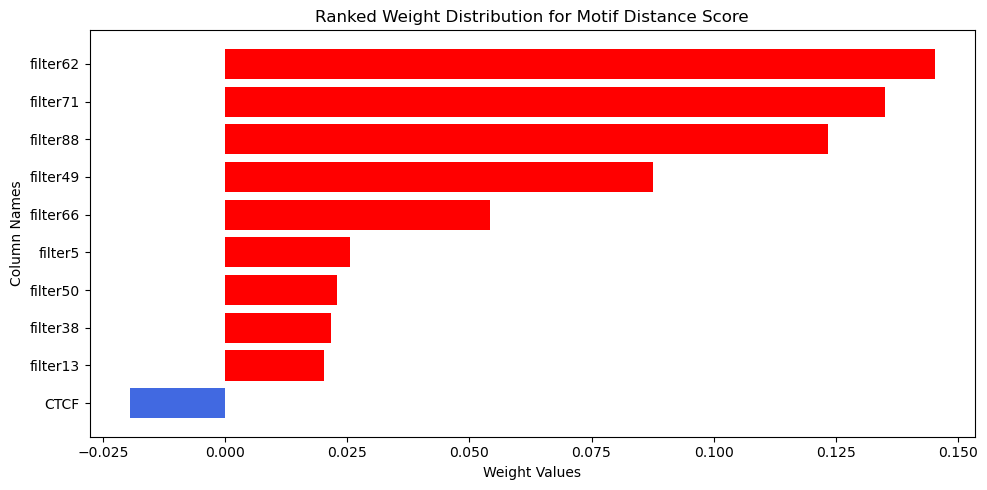

In [11]:
### Plot Bar Plots of Filter Weight Values
plot_filter_weight(weight_df, top_n=10)

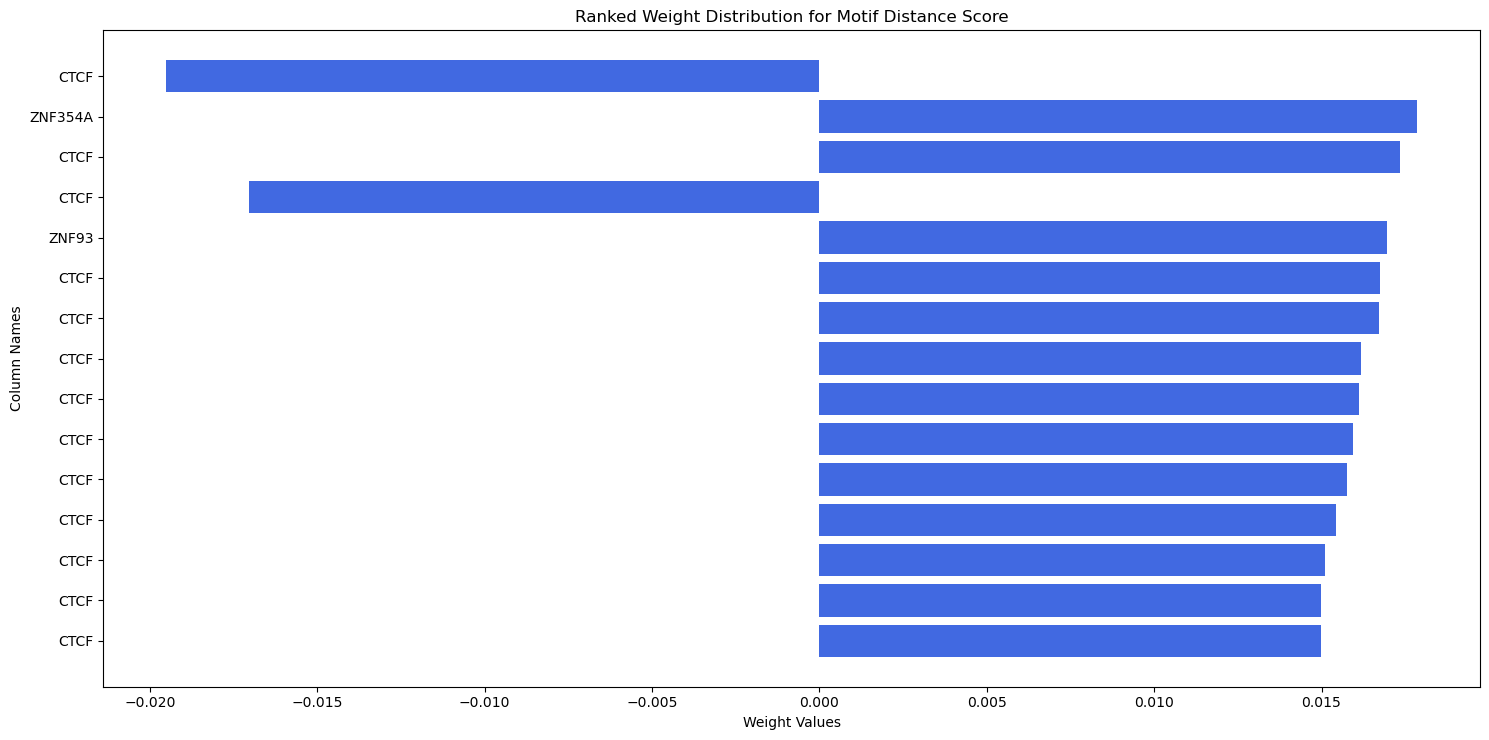

In [12]:
# Remove columns that does not have annotations
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]

plot_filter_weight(ann_wdf, top_n=15)

In [13]:
# Assuming 'interpretation' and 'explainn' are already defined and properly configured
# Also assuming 'data_loader', 'device', and 'annotation' are defined as per your setup

unit_importance_GFP_pos = []
unit_importance_GFP_neg = []
unit_importance_motif_dist_score = []
unit_names = []
unit_filters = []

# Loop through units with indices 0 to 4
for unit_index in range(num_cnns):
    filter_key = "filter" + str(unit_index)
    title = annotation[filter_key] if filter_key in annotation.index else filter_key
    unit_names.append(title)  # Store the unit name for plotting
    unit_filters.append(filter_key) # Store the filter name of each unit for presenting top important filters and motif logo plotting
    
    # Calculate unit importance for the current unit
    unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
    importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, unit_index, target_labels)
    unit_importance_motif_dist_score.append(importance['Motif Distance Score'])

('filter62', 'filter71', 'filter88', 'filter49', 'filter50', 'filter38', 'filter66', 'filter5', 'filter25', 'filter83')


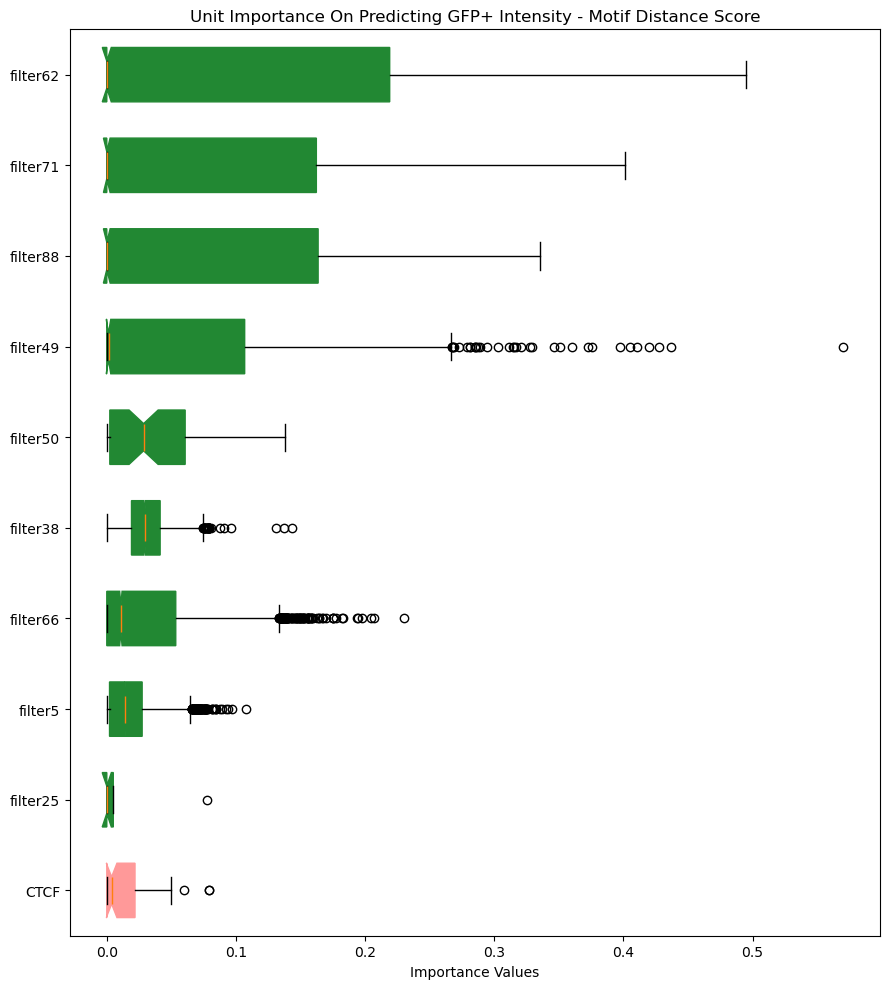

In [14]:
"""Plot the Ranked Importance Value of Each Filter"""
num_filter_plot = 10
# Create a list to store common important filters
common_filters = []

def plot_importance(ax, unit_importance_values, num_filter_plot, title_suffix):
    # Calculate the means of each list in unit_importance_values
    means = [np.mean(values) for values in unit_importance_values]

    # Create tuples of means, unit names, and values, then sort them by means
    sorted_data = sorted(zip(means, unit_names, unit_filters, unit_importance_values), key=lambda x: x[0], reverse=True)

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_filters, sorted_values = zip(*sorted_data)

    # Print top 10 most impoertant filters
    print(sorted_filters[:num_filter_plot])

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_filters, sorted_values = zip(*sorted_data[:num_filter_plot][::-1])

    # Define properties for outliers (fliers)
    flierprops = dict(marker='o', color='black', markersize=6)

    # Create box plots individually to control colors
    box_width = 0.6  # Set box width
    for i, (name, data) in enumerate(zip(sorted_names, sorted_values)):
        color = "#ff9999" if "filter" not in name.lower() else "#228833"
        ax.boxplot(data, positions=[i + 1], widths=box_width, notch=True, patch_artist=True,vert=False,
                   boxprops=dict(facecolor=color, color=color), flierprops=flierprops)

    # Set custom sorted x-axis labels
    ax.set_yticks(range(1, len(sorted_names) + 1))
    ax.set_yticklabels(sorted_names, rotation=0)
    ax.set_title(f"Unit Importance On Predicting GFP+ Intensity - {title_suffix}")
    ax.set_xlabel("Importance Values")

# Create a single plot
fig, ax = plt.subplots(figsize=(9, 10))

# Plot for Motif Distance Score
plot_importance(ax, unit_importance_motif_dist_score, num_filter_plot, "Motif Distance Score")

plt.tight_layout()
plt.show()



In [15]:
def get_specific_unit_importance(activations, model, unit_outputs, filt, target_labels):
    """
    Function to compute unit importance (unit_output*class weight) of a particular ExplaiNN unit (indexed at filt)
    :param activations: numpy.array, matrix of activations of shape (N, U, S); N - size of the dataset;
    U - number of units; S - size of the activation map
    :param model: ExplaiNN model
    :param unit_outputs: numpy.array, outputs of individual units, shape (N, U); N - size of the dataset; U - number of units;
    :param filt: int, index of the unit of interest;
    :param target_labels: a list with the names of the output nodes;
    :return: pandas.Series, contains O keys (number of ExplaiNN outputs, labels), each key contains an array of size X,
    where X is equal to the number of sequences that activated the unit of interest (indexed at filt) more than an
    activation threshold
    """

    activation_threshold = 0.5 * np.amax(activations, axis=(0, 2))
    print(f"activation_threshold shape: {activation_threshold.shape}")
    print(f"activation shape: {activations.shape}")

    # sequences (their indeces) that highly activated the filter
    res = {}
    for i in range(activation_threshold.shape[0]):
        if i != filt: continue # focus on current unit
        inds = []
        print(f"current filter is filter{filt}")
        for j in range(activations.shape[0]):
            # For 590 features at jth sample in the ith cnn, find indices of features that are activated 
            indices = np.where(activations[j, i, :] > activation_threshold[i])
            if indices[0].shape[0] > 0:
                inds.append(j)
        res[i] = inds # inds contains index of samples that have at least 1 activated feature among 590 in the specified cnn filter
    

    weights = model.final.weight.detach().cpu().numpy()  # -0.035227 0.480355
    print(f"weights shape {weights.shape}")

    res_distr = {}
    for cl in range(len(target_labels)):
        # 
        f_cell = np.multiply(unit_outputs, weights[cl])
        print(f'For label {target_labels[cl]}')
        print(f'final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: {f_cell.shape}')
        res_distr[target_labels[cl]] = f_cell[:, filt]
        print(f'interested filter final cell shape" {res_distr[target_labels[cl]].shape}')
        print(f'interested filter final cell sum" {np.sum(res_distr[target_labels[cl]])}')
        res_distr[target_labels[cl]] = res_distr[target_labels[cl]][res[filt]]
        print(f'After removing samples dont have any activated features: {res_distr[target_labels[cl]].shape}')

    res_distr = pd.Series(res_distr)

    return res_distr
# unit_outputs are the output 90 feature values for each sample from ExplaiNN linears layer (before final layer) 
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
print(unit_outputs.shape)
target_labels = ['Motif Distance Score']
importance = get_specific_unit_importance(activations, explainn, unit_outputs, 55, target_labels)
print(f'importance shape: {importance.shape}')
importance

(13825, 90)


activation_threshold shape: (90,)
activation shape: (13825, 90, 590)
current filter is filter55
weights shape (1, 90)
For label Motif Distance Score
final cell shape after multiplying cnn outputs [sample, num_cnn] with weight [1, num_cnn]: (13825, 90)
interested filter final cell shape" (13825,)
interested filter final cell sum" -50.46660614013672
After removing samples dont have any activated features: (99,)
importance shape: (1,)


Motif Distance Score    [-0.012256238, -0.027120681, -0.0020398104, -0...
dtype: object

filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
filter not annotated
CTCF


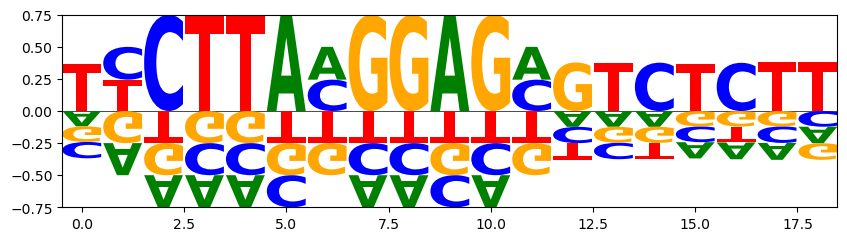

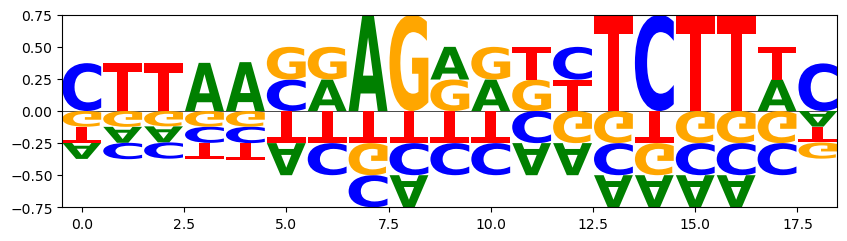

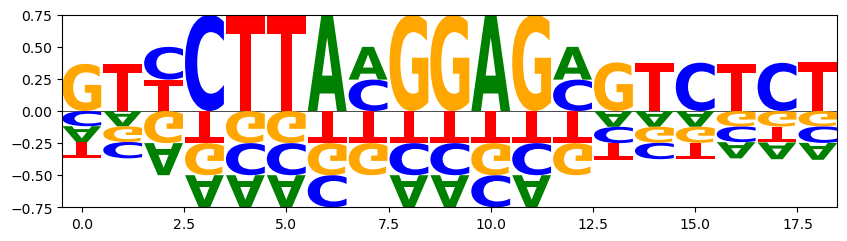

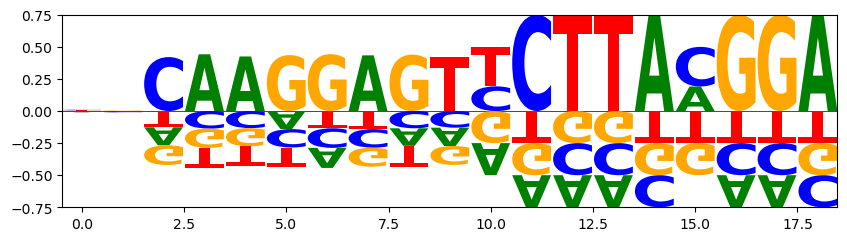

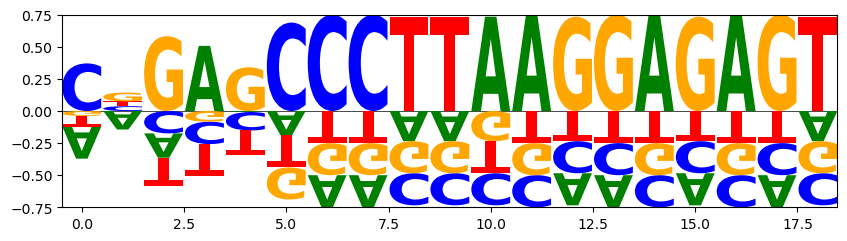

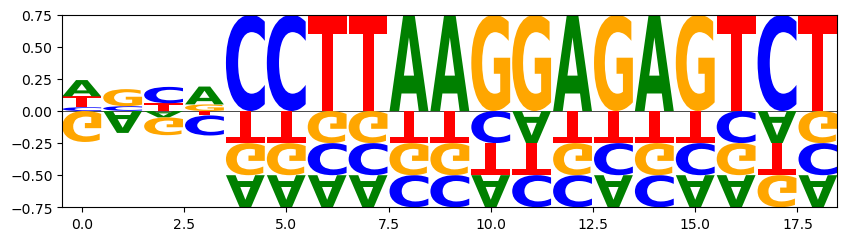

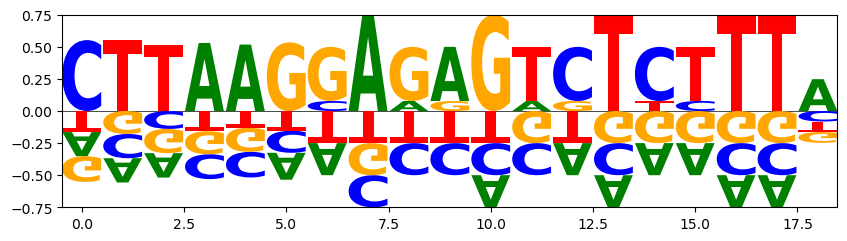

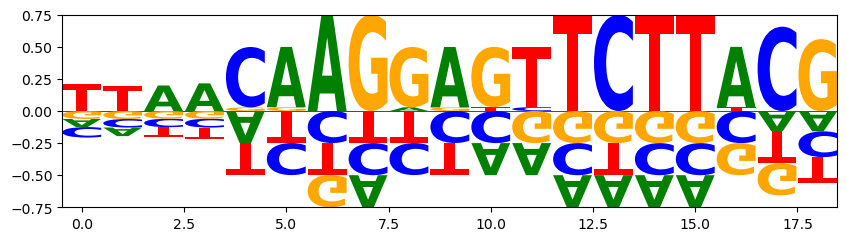

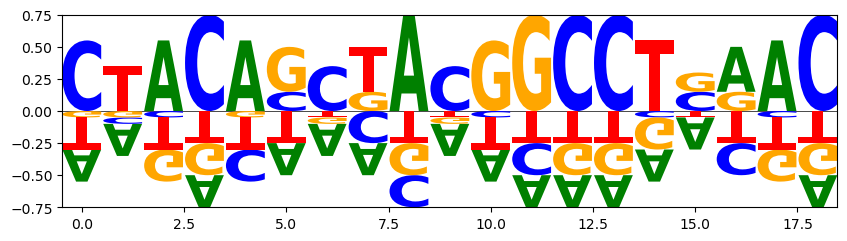

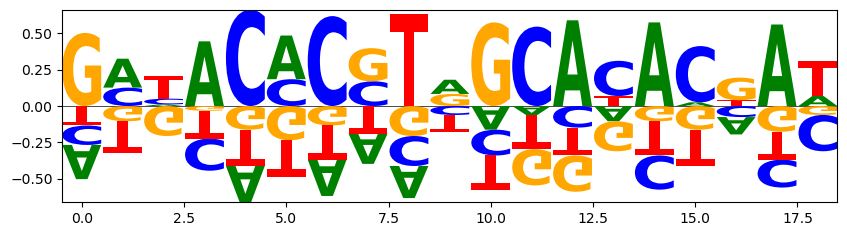

In [16]:
# Generate Motif Logos for top important filter PWMs
motifs, motif_names = tools.read_meme('/pmglocal/ty2514/Enhancer/Enhancer/data/90CNN_synthetic_score_TFBS.meme')

filterid=62
# motifA='CCTTAAGGAGAGTCTCTTT', motifB='CAAGGAGTTCTTACGGAGC'
# For distance score prediction: ('filter62', 'filter71', 'filter88', 'filter49', 'filter50', 'filter38', 'filter66', 'filter5', 'filter25', 'filter83')
for filterid in [62,71,88,49,50,38,66,5,25,83]:
    x = [list(i) for i in motifs[filterid]]
    pwm = tools._PWM_to_filter_weights(x, filter_size)
    nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))
    if ('filter' + str(filterid)) in annotation:
        print(annotation['filter' + str(filterid)])
    else:
        print("filter not annotated")